In [1]:
import torch
import numpy as np
from models.swinir import SwinIR as net
from argparse import Namespace
from glob import glob
import matplotlib.pyplot as plt
import os
import cv2

## Functions

In [2]:
def grid_plot(arr, rows=4, cols=8, scale=1.4, title=None):
    figure = plt.figure(figsize=(int(cols*scale), int(rows*scale)))
    figure.patch.set_facecolor("none")  

    for i in range(cols * rows):
        ax = figure.add_subplot(rows, cols, i+1) 
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

        if title: plt.title(title[i], pad=-1, color="white")
        plt.imshow(arr[i], cmap="gray")

    plt.show()

In [3]:
def define_model(args, img_size):
    model = net(mech = args.mech, num_landmarks=args.num_landmarks, iters =args.iters, upscale=args.scale, in_chans=3, img_size=img_size, window_size=args.window_size,
                img_range=1., depths=[6, 6, 6, 6, 6, 6], embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6],
                mlp_ratio=2, upsampler='pixelshuffle', resi_connection='1conv')
    param_key_g = 'params'
    
    pretrained_model = torch.load(args.model_path, weights_only=True)
    state_dict = pretrained_model[param_key_g] if param_key_g in pretrained_model.keys() else pretrained_model

    model_state_dict = model.state_dict()
    filtered_state_dict = {}

    for key, value in state_dict.items():
        if key in model_state_dict:
            if value.size() == model_state_dict[key].size():
                filtered_state_dict[key] = value

    model_state_dict.update(filtered_state_dict)
    model.load_state_dict(model_state_dict)
    return model

In [4]:
def get_image_pair(args, path):
    (imgname, imgext) = os.path.splitext(os.path.basename(path))

    img_gt = cv2.imread(path, cv2.IMREAD_COLOR).astype(np.float32) / 255.
    img_lq = cv2.imread(f'{args.folder_lq}/{imgname}x{args.scale}{imgext}', cv2.IMREAD_COLOR).astype(
        np.float32) / 255.

    return imgname, img_lq, img_gt

def process(args, path):
    imgname, img_lq, img_gt = get_image_pair(args, path)
    if img_lq.ndim == 3 and img_lq.shape[2] == 3:
        # BGR → RGB
        img_lq = img_lq[:, :, [2, 1, 0]]
    img_lq = np.transpose(img_lq, (2, 0, 1))              # HWC → CHW
    img_lq = torch.from_numpy(img_lq).float().unsqueeze(0).to(args.device)  # 1×C×H×W

    # 4.3) Pad so H & W are multiples of window_size
    _, _, h_old, w_old = img_lq.size()
    h_pad = (h_old // args.window_size + 1) * args.window_size - h_old
    w_pad = (w_old // args.window_size + 1) * args.window_size - w_old

    # vertical flip pad, then trim
    img_lq = torch.cat([img_lq, torch.flip(img_lq, [2])], dim=2)[:, :, : h_old + h_pad, :]
    # horizontal flip pad, then trim
    img_lq = torch.cat([img_lq, torch.flip(img_lq, [3])], dim=3)[:, :, :, : w_old + w_pad]

    return img_lq, img_gt

## codes

In [5]:
params = {
    "scale": 4,
    "model_path":"pretrained_models/SwinIR/x4.pth",
    "folder_lq": "datasets/SwinIR/Set5/LR_bicubic/X4",
    "folder_gt":"datasets/SwinIR/Set5/HR",
    "mech":"original",
    "device":"cuda",
    "num_landmarks":16,
    "iters":2,
    "window_size":8,
}
args = Namespace(**params)

model = define_model(args=args, img_size=64)
model = model.to(args.device)

In [6]:
paths = glob(args.folder_gt+"/*")
imgname, img_lq, img_gt = get_image_pair(args, paths[0])
print(img_lq.shape, img_gt.shape)

(128, 128, 3) (512, 512, 3)


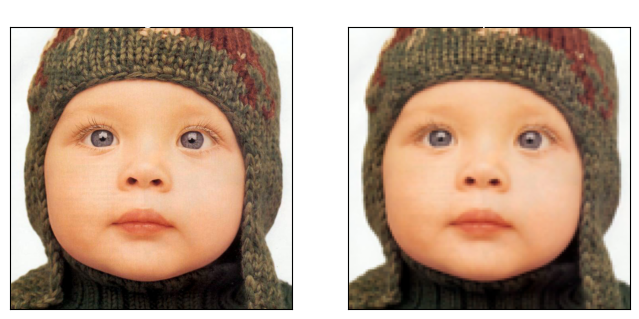

In [7]:
grid_plot([img_gt[:,:,::-1], img_lq[:,:,::-1]], rows=1, cols=2, scale=4, title=["gt", "lq4x"])

In [13]:
model.layers[0].residual_group.blocks[0].attn

WindowAttention(
  dim=180, window_size=(8, 8), num_heads=6
  (qkv): Linear(in_features=180, out_features=540, bias=True)
  (proj): Linear(in_features=180, out_features=180, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (softmax): Softmax(dim=-1)
)

In [14]:
out = model(torch.from_numpy(img_lq).float().permute(2, 0, 1).unsqueeze(0).to(args.device))
out.shape

torch.Size([1, 3, 512, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


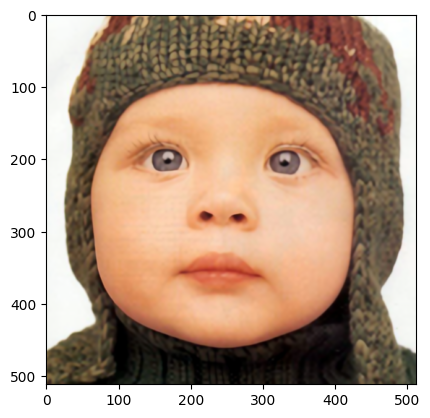

In [15]:
plt.imshow(out.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()[:,:,::-1])

torch.Size([256, 6, 64, 64]) torch.Size([256, 6, 64, 64]) torch.Size([256, 6, 64, 64])


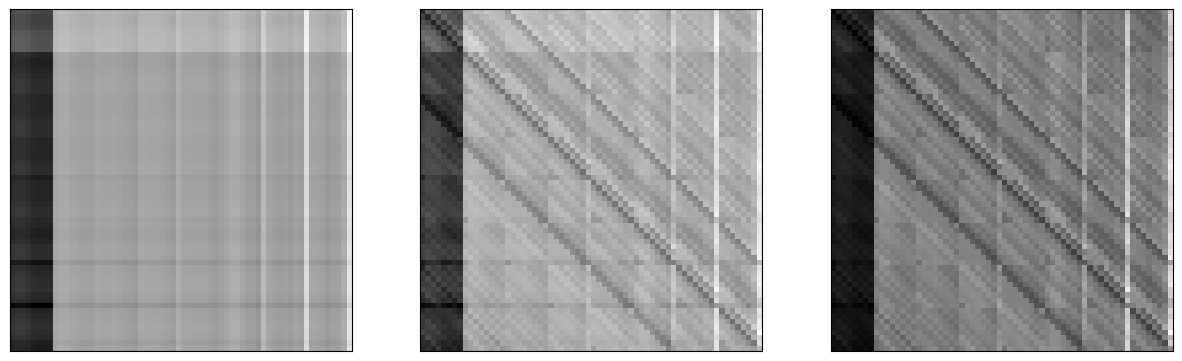

In [62]:
pre = model.layers[0].residual_group.blocks[0].attn.capture['pre']
mid = model.layers[0].residual_group.blocks[0].attn.capture['mid']
post = model.layers[0].residual_group.blocks[0].attn.capture['post']
print(pre.shape, mid.shape, post.shape)

i=1
j=0
grid_plot([pre[i,j], mid[i,j], post[i,j]], rows=1, cols=3, scale=5)